In [2]:
import os
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import json

torch.set_grad_enabled(False)

import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
import numpy as np
import argparse
import sys

current_dir = os.path.dirname(os.path.abspath("/root/projects/continuous_tokenizer/LlamaGen/autoregressive/train/test.ipynb"))
llamagen_path = os.path.abspath(os.path.join(current_dir, "../../"))
sys.path.append(llamagen_path)
from utils.distributed import init_distributed_mode
from dataset.augmentation import center_crop_arr
from dataset.build import build_dataset
from autoregressive.sample.sample_c2i_lib import LlamaGenDecoder

from tqdm import tqdm
from glob import glob

In [1]:
def convert_path(path, force=False):
    if force:
        return os.path.join(llamagen_path, path)
    if os.path.exists(path) or os.path.isabs(path):
        return path
    else:
        return os.path.join(llamagen_path, path)

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--data-path",
    type=str,
    default="/root/projects/continuous_tokenizer/ImageNet/val",
)
parser.add_argument(
    "--vq-model", type=str, default="VQ-16"
)
parser.add_argument(
    "--codebook-size", type=int, default=16384
)
parser.add_argument(
    "--codebook-embed-dim", type=int, default=8
)
parser.add_argument(
    "--ckpt-path",
    type=str,
    default="/root/projects/continuous_tokenizer/LlamaGen/vq_ds16_c2i.pt",
)
parser.add_argument(
    "--code-path",
    type=str,
    default="dataset/ImageNet-1k/llamagen_codes_384/",
)
parser.add_argument("--dataset", type=str, default="imagenet")
parser.add_argument(
    "--image-size", type=int, choices=[256, 384, 448, 512], default=384
)
parser.add_argument(
    "--crop-range", type=float, default=1.1, help="expanding range of center crop"
)
parser.add_argument("--num-workers", type=int, default=16)
parser.add_argument("--global-seed", type=int, default=42)
parser.add_argument("--bsz", type=int, default=1)
parser.add_argument("--single", action="store_true")
args = parser.parse_args([])

args.code_path = convert_path(args.code_path, force=True)
args.ckpt_path = convert_path(args.ckpt_path, force=True)
assert os.path.exists(args.data_path), f"data path {args.data_path} does not exist!"
args.single = True

In [4]:
assert torch.cuda.is_available(), "Training currently requires at least one GPU."
# Setup DDP:
if not args.single:
    init_distributed_mode(args)
    rank = dist.get_rank()
    device = rank % torch.cuda.device_count()
    seed = args.global_seed * dist.get_world_size() + rank
    torch.manual_seed(seed)
    torch.cuda.set_device(device)
    print(f"Starting rank={rank}, seed={seed}, world_size={dist.get_world_size()}.")
else:
    device = "cuda"
    rank = 0

# Setup a feature folder:
if args.single or rank == 0:
    os.makedirs(args.code_path, exist_ok=True)
    os.makedirs(
        os.path.join(args.code_path, f"{args.dataset}{args.image_size}_codes"),
        exist_ok=True,
    )
    os.makedirs(
        os.path.join(args.code_path, f"{args.dataset}{args.image_size}_labels"),
        exist_ok=True,
    )
if not args.single:
    dist.barrier()
done_files = glob(
    os.path.join(
        args.code_path, f"{args.dataset}{args.image_size}_codes", f"{rank}_*.npy"
    )
)
last_index = len(done_files) - 1
print(f"Rank {rank} has done {len(done_files)} files, last index {last_index}.")

Rank 0 has done 0 files, last index -1.


In [6]:
args

Namespace(data_path='/root/projects/continuous_tokenizer/ImageNet/val', ckpt_path='/root/projects/continuous_tokenizer/LlamaGen/vq_ds16_c2i.pt', code_path='/root/projects/continuous_tokenizer/LlamaGen/dataset/ImageNet-1k/llamagen_codes_384/', dataset='imagenet', image_size=384, crop_range=1.1, num_workers=16, global_seed=42, bsz=1, single=True)

In [8]:
vq_model = LlamaGenDecoder(args.ckpt_path, device, args)

/root/projects/continuous_tokenizer/LlamaGen/autoregressive/sample/sample_c2i_lib.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.vq_ckpt, 

In [9]:
crop_size = int(args.image_size * args.crop_range)
transform = transforms.Compose(
    [
        transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, crop_size)),
        transforms.TenCrop(args.image_size), # this is a tuple of PIL Images
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
    ]
)
print("Constructing dataset...")
dataset = build_dataset(args, transform=transform)
if not args.single:
    sampler = DistributedSampler(
        dataset,
        num_replicas=dist.get_world_size(),
        rank=rank,
        shuffle=False,
        seed=args.global_seed,
    )
else:
    sampler = None


Constructing dataset...


In [10]:
loader = DataLoader(
    dataset,
    batch_size=1,  # important!
    shuffle=False,
    sampler=sampler,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False,
)
progress_bar = tqdm(
        loader, desc="Processing", #disable=(not args.single and rank != 0)
    )

Processing:   0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
total = 0
x_concat = []
y_concat = []
index = 0
for p, x, y in progress_bar:
    break

Processing:   0%|          | 0/50000 [00:02<?, ?it/s]


In [12]:
x.shape

torch.Size([1, 10, 3, 384, 384])

In [13]:
bsz = x.shape[0]
n_aug = x.shape[1]
x = x.to(device).flatten(0, 1) # shape: (bsz * n_aug, 3, H, W)

In [14]:
x.shape

torch.Size([10, 3, 384, 384])

In [17]:
vq_model.encode(x).shape

torch.Size([10, 576])

In [15]:
encoded_tokens = vq_model.encode(x).view(bsz, n_aug, -1).cpu().numpy()

In [46]:
for i in range(bsz):
                x = encoded_tokens[i]
                x_concat.append(x)
                y_concat.append(
                    {"label": y[i].item() if isinstance(y, torch.Tensor) else y[i], "path": p[i]}
                )

In [47]:
y_concat

[{'label': 0,
  'path': '/root/projects/continuous_tokenizer/ImageNet/val/n01440764/ILSVRC2012_val_00000293.JPEG'}]

In [16]:
encoded_tokens.shape

(1, 10, 576)

In [39]:
def denormalize(img, resize=False):
    import torch.nn.functional as F
    dfi = torch.clamp((img + 1) / 2, 0, 1)
    if resize:
        # F.interpolate expects input of shape [N, C, H, W]
        dfi = F.interpolate(dfi.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
    dfiimg = (dfi.permute(1, 2, 0).cpu().numpy() * 255).round().astype(np.uint8)
    return dfiimg

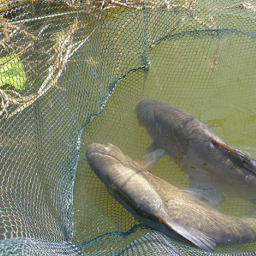

In [41]:
Image.fromarray(denormalize(x[0], True))

In [43]:
qzshape = [1, args.codebook_embed_dim, 24, 24]

In [35]:
encoded_tokens[0].shape

(10, 576)

In [37]:
def decode(ids, args): # ids should be [B, N]
    bsz = ids.shape[0]
    length = ids.shape[1]
    latent_size = int(length ** 0.5)
    assert latent_size * latent_size == length, "length should be a perfect square."
    qzshape = [bsz, args.codebook_embed_dim, latent_size, latent_size]
    return vq_model.vq_model.decode_code(ids, qzshape).detach()

In [38]:
decode(encoded_tokens[0], args).shape

torch.Size([10, 3, 384, 384])

In [33]:
vq_model.vq_model.decode_code(encoded_tokens[0], qzshape).shape

torch.Size([10, 3, 384, 384])

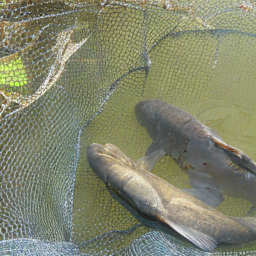

In [45]:
Image.fromarray(denormalize(vq_model.vq_model.decode_code(encoded_tokens[0][0], [1, args.codebook_embed_dim, 24, 24])[0], True))

In [ ]:
for i in range(bsz):
    x = encoded_tokens[i]
    x_concat.append(x)
    y_concat.append(
        {"label": y[i].item() if isinstance(y, torch.Tensor) else y[i], "path": p[i]}
    )